# Get images of each label that each model gets right

In [114]:
%load_ext autoreload
%autoreload 2
import os, sys, json
import pandas as pd
import numpy as np
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of vit_grad_rollout.vit_grad_rollout failed: Traceback (most recent call last):
  File "/cis/home/zmurphy/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/cis/home/zmurphy/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/cis/home/zmurphy/my_documents/tr

In [115]:
with open('/cis/home/zmurphy/code/transformer-radiographs/cfg.json'.replace('~', os.path.expanduser('~')), 'r') as f:
    cfg = json.load(f)
    
deit_test = '/cis/home/zmurphy/code/data/results/final/DeiT_lr0.05_bs16_optSGD_wd1e-05_sch_step_pp3_bp5_trtrain_all.txt_vatest.txt_tfhflip_nllayer_do0.0_1624113464.pkl'
dn_test = '/cis/home/zmurphy/code/data/results/final/DenseNet121_lr0.05_bs16_optSGD_wd0.0001_sch_step_pp3_bp5_trtrain_all.txt_vatest.txt_tfhflip_nlbatch_do0.5_1624137117.pkl'
thresh_file = '/cis/home/zmurphy/code/data/results/final/CXR100_final/results_table.csv'

labels = cfg['labels_chexnet_14_standard']

dataset = 'mimic'

In [116]:
# Get thresholds
thresh = pd.read_csv(thresh_file)

# Deit
thresh_deit = thresh[(thresh['Set']=='{}_test'.format(dataset))&(thresh['Model']=='DeiT-B')&(thresh['Measure'].isin(['thresh_{}'.format(x) for x in labels]))]
thresh_deit['Measure'] = thresh_deit['Measure'].apply(lambda x: x.replace('thresh_',''))
thresh_deit.set_index('Measure', inplace=True)
thresh_deit = thresh_deit['Mean']
thresh_deit = thresh_deit.to_dict()
thresh_deit

# DN
thresh_dn = thresh[(thresh['Set']=='{}_test'.format(dataset))&(thresh['Model']=='DenseNet121')&(thresh['Measure'].isin(['thresh_{}'.format(x) for x in labels]))]
thresh_dn['Measure'] = thresh_dn['Measure'].apply(lambda x: x.replace('thresh_',''))
thresh_dn.set_index('Measure', inplace=True)
thresh_dn = thresh_dn['Mean']
thresh_dn = thresh_dn.to_dict()
thresh_dn

thresh = {'deit': thresh_deit, 'dn':thresh_dn}
thresh

/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'deit': {'Atelectasis': 0.12472043360769748,
  'Cardiomegaly': 0.029847397707402707,
  'Effusion': 0.16319569873809814,
  'Infiltration': nan,
  'Mass': nan,
  'Nodule': nan,
  'Pneumonia': 0.0142530904058367,
  'Pneumothorax': 0.01436997843440622,
  'Consolidation': 0.045223655831068764,
  'Edema': 0.01160159358661622,
  'Emphysema': nan,
  'Fibrosis': nan,
  'Pleural_Thickening': nan,
  'Hernia': nan},
 'dn': {'Atelectasis': 0.18386863458156585,
  'Cardiomegaly': 0.03583105651289225,
  'Effusion': 0.19046844670176505,
  'Infiltration': nan,
  'Mass': nan,
  'Nodule': nan,
  'Pneumonia': 0.018358949685469268,
  'Pneumothorax': 0.029094236677512524,
  'Consolidation': 0.06642546544969083,
  'Edema': 0.018279770027846098,
  'Emphysema': nan,
  'Fibrosis': nan,
  'Pleural_Thickening': nan,
  'Hernia': nan}}

In [117]:
def get_correct_pos_images(test_file, thresh):
  with open(test_file, 'rb') as f:
    dat = pickle.load(f)
  dat = dat['{}_test'.format(dataset)]
  dat = pd.DataFrame().from_dict(dat)

  for i, l in enumerate(labels):
    dat['y_{}'.format(l)] = dat['y'].apply(lambda x: x[i])
  for i, l in enumerate(labels):
    dat['yhat_{}'.format(l)] = dat['yhat'].apply(lambda x: x[i])
  for i, l in enumerate(labels):
    dat['thresh_{}'.format(l)] = thresh[l]
  for i, l in enumerate(labels):
    dat['ypred_{}'.format(l)] = (dat['yhat_{}'.format(l)] >= dat['thresh_{}'.format(l)]).astype(int)

  # Get images with only one label
  dat['gt_pos'] = dat[['y_{}'.format(l) for l in labels]].sum(axis=1)
  dat = dat[dat['gt_pos']==1]
  
  # # Get images with one activation
  # dat['pred_pos'] = dat[['ypred_{}'.format(l) for l in labels]].sum(axis=1)
  # dat = dat[dat['pred_pos']==1]

  # Get label that's positive
  dat['pos_label'] = dat[['y_{}'.format(l) for l in labels]].apply(lambda x: np.argmax(x), axis=1)

  # Get only those predicted correctly for pos label
  idxs = []
  for i, r in dat.iterrows():
    if r['ypred_{}'.format(labels[r['pos_label']])]==1:
      idxs.append(i)
  dat = dat.loc[idxs]
  
  # # Get only those with one pos activation
  # dat = dat[dat[['ypred_{}'.format(l) for l in labels]].sum(axis=1)==1]

  # Get only file and label
  dat['pos_label'] = dat['pos_label'].apply(lambda x: labels[x])
  dat = dat[['file','pos_label']]
  print(dat.shape)
  return dat

deit_list = get_correct_pos_images(deit_test, thresh['deit'])
dn_list = get_correct_pos_images(dn_test, thresh['dn'])

(4220, 2)
(4136, 2)


In [118]:
dat = pd.merge(deit_list,dn_list, on=['file','pos_label'], how='inner')
dat['file'] = dat['file'].apply(lambda x: x.split('/')[-1])

images_to_test = []
for l in labels:
  dat_ = dat[dat['pos_label']==l]
  # Get up to 25
  images_to_test.extend(dat_['file'].sample(n=min(25,dat_.shape[0]), random_state=1234).tolist())
print(len(images_to_test))
pd.Series(images_to_test).to_csv(os.path.join(cfg['data_dir'], '{}/test_compare_map.txt'.format(dataset)), index=False, header=False)

175


# DeiT attention map code

In [119]:
"""Imports"""
import os, sys, shutil, json
import pandas as pd
import numpy as np
import pickle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
import matplotlib.cm as cm

!pip install opencv-python
import cv2
!pip install nopdb
import nopdb

from vit_grad_rollout.vit_grad_rollout import VITAttentionGradRollout
from vit_grad_rollout.vit_rollout import VITAttentionRollout

# Custom
sys.path.append('../')
import custom_modules as CXR

"""Set GPU"""
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0' # <------ Be sure to set the right GPU!!!
device='cuda'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [120]:
"""Config"""
with open('/cis/home/zmurphy/code/transformer-radiographs/cfg.json'.replace('~', os.path.expanduser('~')), 'r') as f:
    cfg = json.load(f)
    
# CXR
deit_model_state = '/cis/home/zmurphy/code/data/results/final/DeiT_lr0.05_bs16_optSGD_wd1e-05_sch_step_pp3_bp5_trtrain_all.txt_vatest.txt_tfhflip_nllayer_do0.0_1624113464_model.pt'
dn_model_state =   '/cis/home/zmurphy/code/data/results/final/DenseNet121_lr0.05_bs16_optSGD_wd0.0001_sch_step_pp3_bp5_trtrain_all.txt_vatest.txt_tfhflip_nlbatch_do0.5_1624137117_model.pt'
model_args = {
    'labels_set': 'chexnet-14-standard',
    'labels': cfg['labels_chexnet_14_standard'],
    'n_labels': len(cfg['labels_chexnet_14_standard']),
    'batch_size': 1,
    'data_dir': cfg['data_dir'],
    'dataset': dataset,
    'test_file': 'test_compare_map.txt',
    'use_parallel': 'y',
    'num_workers': 12,
    'img_size': 224,
    'print_batches': False,
    'scratch_dir':'/export/gaon1/data/zmurphy/transformer-cxr',
    'results_dir':'/export/gaon1/data/zmurphy/transformer-cxr/results/final'
}


# ImageNet mean, std
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])


In [121]:
"""Load data"""
dataset_root = os.path.join(model_args['data_dir'], model_args['dataset'])

# CXR
test_data = CXR.CXRDataset(images_list=os.path.join(dataset_root, model_args['test_file']),
                            dataset=model_args['dataset'],
                            images_dir=os.path.join(dataset_root, 'images'),
                            image_paths=os.path.join(dataset_root, 'image_paths.txt'),
                            labels_file=os.path.join(dataset_root, 'labels.csv'),
                            labels=model_args['labels'],
                            transform='none',
                            op='test',
                            img_size=model_args['img_size'])

testLoader = DataLoader(test_data, batch_size=model_args['batch_size'],
                         pin_memory=True, shuffle=False,
                         num_workers=model_args['num_workers'])



Test set: starting load
Using image path file
Using no transforms
Loaded 175 images


In [122]:
"""Get deit model and set state"""
torch.hub.set_dir('base_model_states')
model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

# CXR
model_deit.head = nn.Sequential(nn.Linear(in_features=768, out_features=model_args['n_labels']), nn.Sigmoid())
model_deit.load_state_dict(torch.load(deit_model_state, map_location=torch.device('cpu')))

# Test
model_deit.eval()

# Model to GPU
model_deit = model_deit.to(device)
model_deit.training


Using cache found in base_model_states/facebookresearch_deit_main


False

In [123]:
"""DenseNet121"""
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# DenseNet-121
model_dn = torchvision.models.densenet121(pretrained=True)
model_dn.classifier = nn.Sequential(nn.Linear(in_features=1024, out_features=model_args['n_labels']), nn.Sigmoid())
model_dn.load_state_dict(torch.load(dn_model_state, map_location=torch.device(device)))

model_dn.eval()

# Model to GPU
model_dn = model_dn.to(device)

model_dn.training

False

In [131]:
cmap=cm.get_cmap('jet',256)
grad_rollout = VITAttentionGradRollout(model_deit, discard_ratio=0.9, device=device)
cam = GradCAMPlusPlus(model=model_dn, target_layers=[model_dn.features[-1]], use_cuda=True)
attn_rollout = VITAttentionRollout(model_deit, discard_ratio=0.9, head_fusion='max', device=device)

def get_attn(x, y_idx):
  x = x.to(device)
  attn_map = grad_rollout(x, category_index=y_idx)
  # attn_map = attn_rollout(x)
  attn_map = cmap(cv2.resize(attn_map, dsize=(224,224)))
  x = x.to(device)
  return attn_map

def get_gradcam(x,y_idx):
  
  targets = [ClassifierOutputTarget(y_idx)]
  grayscale_cam = cam(input_tensor=x, targets=targets, aug_smooth=True)
  # grayscale_cam = grayscale_cam - grayscale_cam.min()
  # grayscale_cam = grayscale_cam/grayscale_cam.max()
  grayscale_cam = cmap(cv2.resize(grayscale_cam.squeeze(0), dsize=(224,224)))
  return grayscale_cam

In [133]:
"""Loop through input images"""
target_dir='attn_maps_{}'.format(dataset)
if os.path.exists(target_dir):
  shutil.rmtree(target_dir)
os.mkdir(target_dir)


ct = 0
for x, y, file in testLoader:
  y_idx = y.argmax()
  
  # Get GadCAM
  grayscale_cam = get_gradcam(x,y_idx)
  
  # Get attention map and yhat
  attn_map = get_attn(x, y_idx)

  # Reverse ImageNet mean & std for CXR
  im = x.squeeze(0)
  im = im * std[:, None, None] + mean[:, None, None]

  # Plot
  fig, ax = plt.subplots(1,3, figsize=(10,5))
  fig.patch.set_facecolor('white')
  ax[0].imshow(im.numpy().transpose(1, 2, 0))
  ax[1].imshow(attn_map)
  ax[2].imshow(grayscale_cam)

  ax[0].set_title('Input')
  ax[1].set_title('DeiT-B')
  ax[2].set_title('DenseNet121')

  [ax[ax_i].axis('off') for ax_i in range(3)]

  # Get labels for image
  labs = []
  for l in range(model_args['n_labels']):
    if y[0][l] == 1:
      labs.append(model_args['labels'][l])
  if len(labs) == 0:
    plt.suptitle(file[0][file[0].rfind('/')+1:] + '\n' + 'No findings')
  else:
    plt.suptitle(file[0][file[0].rfind('/')+1:] + '\n' + ', '.join(labs))

  # Show plot
  fig.tight_layout()
  os.makedirs(os.path.join(target_dir,labels[np.argmax(y[0])]), exist_ok=True)
  plt.savefig(os.path.join(target_dir,labels[np.argmax(y[0])], file[0][file[0].rfind('/')+1:]),bbox_inches='tight')
  plt.close()

  ct += 1
  print('\r{}'.format(ct),end='')
  if ct == 3:
    break

3

# Test on ImageNet to make sure it's working

Using cache found in ./export/gaon1/data/zmurphy/transformer-cxr/results/facebookresearch_deit_main


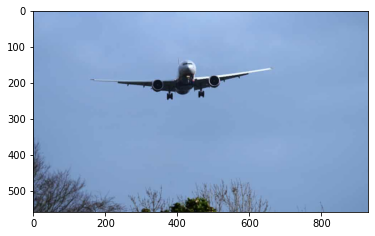

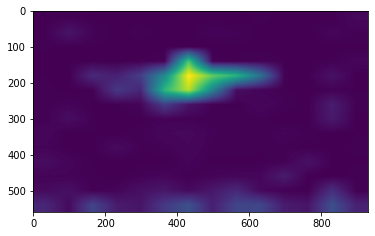

In [153]:
from torchvision import transforms
from PIL import Image
# DenseNet-121
model_dn = torchvision.models.densenet201(pretrained=True)

torch.hub.set_dir('.'+'/export/gaon1/data/zmurphy/transformer-cxr/results'.replace('.','_'))
model_deit_im = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model_deit_im.eval()
model_deit_im = model_deit_im.to(device)

tfms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224,224), transforms.functional.InterpolationMode.BILINEAR),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

file_name = 'airplane2'
img_raw = Image.open('../google_images/'+file_name+'.jpeg')
img = tfms(img_raw).unsqueeze(0)

plt.imshow(img_raw)
plt.show()
img = img.to(device)
grad_rollout = VITAttentionGradRollout(model_deit_im, discard_ratio=0.9, device=device)
attn_map = grad_rollout(img, category_index=895)
attn_map = cv2.resize(attn_map, dsize=img_raw.size)
plt.imshow(attn_map)
plt.show()

# cam = GradCAM(model=model_dn, target_layers=[model_dn.features[-1]], use_cuda=False)

# gs = cam(img)
# gs = cv2.resize(gs.squeeze(), dsize=img_raw.size)
# plt.imshow(img_raw)
# plt.show()
# plt.imshow(gs)